In [52]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

import cftime
import numpy as np
import matplotlib.dates as mdates

In [53]:
df_cfc11 = pd.read_csv("../data/input/f11_gblannualdata", skiprows=1, sep=r'\s+', names=["year", "CFC11"]).set_index("year")
df_cfc12 = pd.read_csv("../data/input/f12_gblannualdata", skiprows=1, sep=r'\s+', names=["year", "CFC12"]).set_index("year")
df_sf6 = pd.read_csv("../data/input/sf6_monthly_cmip6_from_esgf.csv", skiprows=1, names=["time", "SF6"])
df_sf6['year'] = [np.int64(t[:4]) for t in df_sf6['time']]
df_sf6 = df_sf6.groupby('year').mean(numeric_only=True)

In [54]:
bc = xr.open_dataset("/archive/oar.gfdl.cmip6/datasets/OMIP/cfc/CFC_histories_revised_2015_20x20deg.20171208.nc", decode_times=False) # file for the historical run
bc_new = bc.copy()
bc_new['Time'] = bc_new['Time'] + 1601. # convert to CE years for convenient referencing and temporal interpolation
bc_new = bc_new.interp(Time = np.append(bc_new['Time'].values[:-2], np.arange(2015.5, 3000., 1.)), kwargs={"fill_value": "extrapolate"})

for i, t in enumerate(bc_new['Time']):
    if t>2015:
        # Remove global mean (but leave behind hemispheric spatial pattern) and add in global mean from SSP5-8.5 protocol
        if any(df_cfc11.index==t.values):
            bc_new['CFC11'][i,:,:] += -bc_new['CFC11'].sel(Time=t.values).mean() + df_cfc11['CFC11'].loc[df_cfc11.index==t.values].values[0]
            bc_new['CFC12'][i,:,:] += -bc_new['CFC12'].sel(Time=t.values).mean() + df_cfc12['CFC12'].loc[df_cfc12.index==t.values].values[0]
            bc_new['SF6'][i,:,:] += -bc_new['SF6'].sel(Time=t.values).mean() + df_sf6['SF6'].loc[df_sf6.index==np.int64(np.floor(t.values))].values[0]
            t_last = t
        else:
            bc_new['CFC11'][i,:,:] += -bc_new['CFC11'].sel(Time=t.values).mean() + df_cfc11['CFC11'].loc[df_cfc11.index==t_last.values].values[0]
            bc_new['CFC12'][i,:,:] += -bc_new['CFC12'].sel(Time=t.values).mean() + df_cfc12['CFC12'].loc[df_cfc12.index==t_last.values].values[0]
            bc_new['SF6'][i,:,:] += -bc_new['SF6'].sel(Time=t.values).mean() + df_sf6['SF6'].loc[df_sf6.index==np.int64(np.floor(t_last.values))].values[0]

bc_new['Time'] = bc_new['Time'] - 1601. # convert back to years since 1601
bc_new['Time'].attrs = bc['Time'].attrs

# Line up with control experiment, which begins in 101.
bc_new = bc_new.sel(Time=slice(1849-1601, None))
bc_new['Time'] = bc_new['Time'] - (1850-1601) + 100
bc_new['Time'].attrs = bc['Time'].attrs
bc_new['Time'].attrs['units'] = 'years since 0001-01-01 00:00:00'

encoding = {v: {"_FillValue": 1e+20} for v in list(bc_new.data_vars) + list(bc_new.coords)}
bc_new.to_netcdf("/archive/hfd/datasets/input_files/CFC_SSP585_20x20deg_piControl.20231015.nc", mode="w", encoding=encoding)

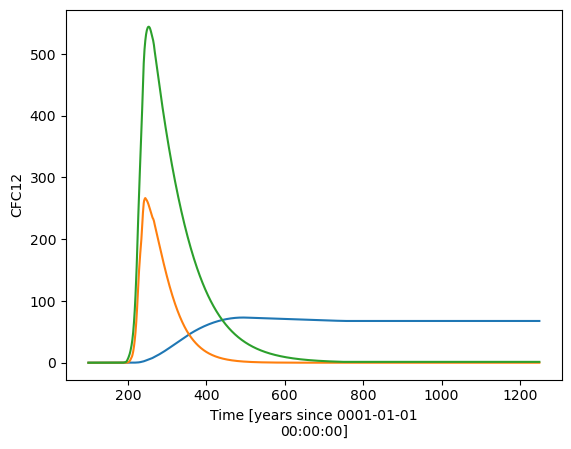

In [55]:
bc_new["SF6"].mean(["Longitude", "Latitude"]).plot()
bc_new["CFC11"].mean(["Longitude", "Latitude"]).plot()
bc_new["CFC12"].mean(["Longitude", "Latitude"]).plot()

In [56]:
bc_new.close()